# ESTIMACIÓN DE PROBABILIDADES DE INCUMPLIMIENTO EN EL TIEMPO

La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La probabilidad de incumplimiento se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante 90 días o más.

## 1. Objetivo:

Análisis de las Probabilidades de Incumplimiento de créditos hipotecarios de Estados Unidos para identificar periodos de crisis mediante el uso de las herramientas vistas en el curso de Análisis Numérico y Computo Científico.

## 2. Datos:

Se utilizará la información de 60 trimestres de 5000 créditos hipotecarios de Estados Unidos tomada de protafolios bursatilizado (RMBSs) a partir del año 2000 (hasta 2015). El proveedor de la base es el International Financial Reasearch (www.internationalfinancialreaserch.org), y se tiene acceso a ella por la adquisición del libro Deep Credit Risk de Daniel Rosch y Harald Scheule, que es la principal fuente de este trabajo.

## 3. Desarrollo:

### Importación de la librería

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import io
import sys
import os
from pytest import approx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, roc_auc_score

/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/eduardomorenoortiz/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
# Importar funciones de utils
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"/utils")

from utils import *

### Lectura del archivo, decodificación  y conversión a dataframe

In [3]:
data = pd.read_csv('../data_t_final.csv')

In [4]:
modeling1 = data.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time']).copy()

Uso de la función `estim_prob` que resuelve el problema de optimización.

In [5]:
fitted_values , model = estim_prob(modeling1,['default_time', 'balance_time','interest_rate_time',
                                               'rate_time','hpi_time',
                                               'gdp_time','uer_time','REtype_CO_orig_time','REtype_SF_orig_time',
                                               'investor_orig_time','balance_orig_time','FICO_orig_time','LTV_orig_time',
                                               'Interest_Rate_orig_time','hpi_orig_time','LTV_time'])

62153
Evaluación de valor óptimo al resolver problema de optimización 13296.454946928172


Los coeficientes de la regresión logística son los siguientes:

In [6]:
model

array([-4.79445901e+00,  9.18681982e-06,  1.86017519e-01,  1.17903495e-01,
       -1.34400214e-02, -9.34643787e-02, -4.08566137e-02, -4.45179488e-02,
       -7.71018732e-03,  1.90200068e-01, -8.69105675e-06, -3.72106218e-03,
        2.22413273e-02, -2.15337731e-02,  1.47555696e-02, -3.05597462e-03])

Como comparación al modelo obtenido se utilizará el modelo modelo utilizando la librería [smf](https://www.statsmodels.org/stable/generated/statsmodels.formula.api.ols.html).

In [7]:
model_lr = smf.glm('default_time ~   balance_time + interest_rate_time + rate_time + hpi_time + uer_time + REtype_CO_orig_time + gdp_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time + LTV_time ', family = sm.families.Binomial(), data = modeling1).fit()

In [8]:
print(model_lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62137
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6648.2
Date:                Wed, 09 Dec 2020   Deviance:                       13296.
Time:                        00:16:27   Pearson chi2:                 5.76e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

A continuación se muestran las principales métricas del modelo. Podemos notar que las siguientes variables no son significativas : `REtype_CO_orig_time` y `REtype_CO_orig_time`; es decir, su aportación a la varianza explicada de la variable dependiente default_time es casi nula en presencia de las demás variables del modelo.

Verificaremos que los coeficientes entre ambas estimaciones son similares, calcularemos la aproximación de ambos vectores con approx de pytest.

In [9]:
print(model == approx(np.array(model_lr.params), abs=1e-1, rel=1e-1))

True


In [10]:
PD_logit_model = pd.DataFrame(fitted_values, columns=['PD_logit_model'])

In [11]:
data2 = pd.merge(modeling1[['default_time','time']],PD_logit_model, right_index=True, left_index=True)

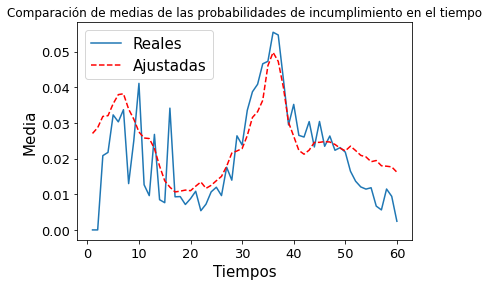

In [12]:
grafica_medias(data2.PD_logit_model, data2.default_time, data2.time)

La grafica muestra un compartamiento similar del ajuste contra los valores reales.
Podemos notar que tanto en periodos de incumplimiento bajo y alto la tendencia sigue el mismo patrón. Nótese que alrededor del periodo treinta creció debido a la crisis inmobiliaria del 2008-2009.

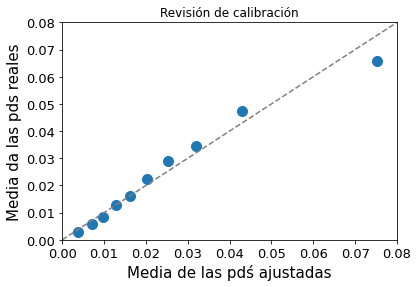

In [13]:
grafica_ajuste(data2.PD_logit_model, data2.default_time, data2.time)

El ajuste de las medias reales contra las medias ajustadas no presenta desviaciones considerables, incluso para valores dispersos esta comportamiento se mantiene.

### Componentes principales

El analisis de componentes principales se hará para ejemplificar la reducción de dimensionalidad de la variable 'estado' y poder incorporarla al modelo de predicción logístico.

Cálculo de tasas y estandarización

In [14]:
defaultrates_states1 = modeling1.groupby(['time','state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('defaultrate_').fillna(0).reset_index(drop=False)
scaler = StandardScaler()
defaultrates_states = scaler.fit_transform(defaultrates_states1)
cov = np.cov(defaultrates_states.T)

Obtener componentes principales usando método de potencia y deflación que nos ayudan a encontrar los eigenvectores asociados a los 2 eigenvalores de máximo módulo, respectivamente.

In [15]:
eigenvalor,eigenvector = potencia(cov,MAX=1000)
eigenvalor2,eigenvector2 = deflacion(cov,MAX=1000)
cp1 = eigenvector@defaultrates_states.T
cp2 = eigenvector2@defaultrates_states.T

### Resolucion del problema utilizando funciones predeterminadas

In [16]:
pca=PCA()
pca.fit(defaultrates_states)
z = pca.transform(defaultrates_states)

### Comparación de resultados entre los diferentes métodos

Verificaremos que las componentes principales entre ambas estimaciones sean similares, calcularemos la aproximación con approx de pytest.

In [17]:
print(cp1 == approx(z[:,0], abs=1e-1, rel=1e-1))
print(-cp2 == approx(z[:,1], abs=1e-1, rel=1e-1))

True
True


### Introduccion de las componentes princiaples a la base de datos

Una vez obtenido las dos compementos principales de mayor importancia, la importancia de la componente principal depende del módulo del eigenvalor respectivo. Procedemos a incoporarlas a las variables predictivas para posteriormente incoporar una regresión logística.

In [18]:
cpa = pd.DataFrame(pd.DataFrame([cp1,-cp2,defaultrates_states1['time']]).T)
cpa = cpa.rename(columns={0:'cpa1',1:'cpa2',2:'time' })
data_cpa = modeling1.merge(cpa,how='left')

### Resolucion del problema utilizando herramientas avanzadas de optimizacion

Uso de la función `estim_prob` que resuelve el problema de optimización.

In [19]:
fitted_values_cpa , model_cpa = estim_prob(data_cpa,['default_time', 'balance_time','interest_rate_time',
                                               'rate_time','hpi_time',
                                               'gdp_time','uer_time','REtype_CO_orig_time','REtype_SF_orig_time',
                                               'investor_orig_time','balance_orig_time','FICO_orig_time','LTV_orig_time',
                                               'Interest_Rate_orig_time','hpi_orig_time','LTV_time',
                                               'cpa1','cpa2'])

62153
Evaluación de valor óptimo al resolver problema de optimización 13243.32927189312


Los coeficientes de la regresión logística son los siguientes:

In [20]:
model_cpa

array([-5.54615540e+00,  9.04533711e-06,  1.76300228e-01,  1.50202163e-01,
       -1.00413224e-02,  1.75921891e-02,  9.93697611e-03, -4.53573320e-02,
       -3.66635373e-03,  1.85161596e-01, -8.57712500e-06, -3.87231407e-03,
        2.18709999e-02, -2.16364377e-02,  1.23083151e-02, -2.97471148e-03,
        1.24939378e-01,  9.27516633e-03])

### Resolucion del problema utilizando funciones predeterminadas

In [21]:
model_lr_cpa = smf.glm('default_time ~   balance_time + interest_rate_time + rate_time + hpi_time + gdp_time + uer_time + REtype_CO_orig_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time + LTV_time + cpa1 + cpa2', family = sm.families.Binomial(), data = data_cpa).fit()

### Comparacion de resultados entre los diferentes metodos

Verificaremos que los coeficientes entre ambos son similares, calcularemos la aproximación de ambos vectores con approx de pytest.

In [22]:
print(model_cpa == approx(np.array(model_lr_cpa.params), abs=1e-1, rel=1e-1))

True


In [23]:
print(model_lr_cpa.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62135
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6621.7
Date:                Wed, 09 Dec 2020   Deviance:                       13243.
Time:                        00:17:49   Pearson chi2:                 5.73e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

Podemos notar que al incoporar la información de los `state_orig_time` las variables que no son significativas vuelven a ser `REtype_CO_orig_time` y `REtype_CO_orig_time`.

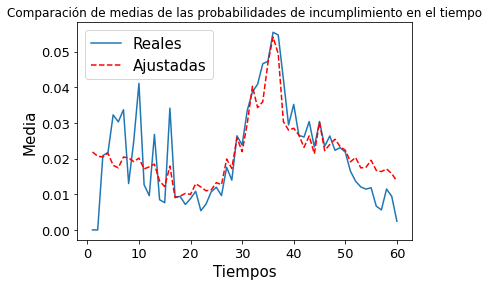

In [24]:
PD_logit_model_cpa = pd.DataFrame(fitted_values_cpa, columns=['PD_logit_model'])
data2_cpa = pd.merge(modeling1[['default_time','time']],PD_logit_model_cpa, right_index=True, left_index=True)
grafica_medias(data2_cpa.PD_logit_model, data2_cpa.default_time, data2_cpa.time)

La grafica muestra una subestimacion en la probabilidad de incumplimiento para los primeros periodos, mientras que a partir del tiempo 20 la estimacion muestra un comportamiento muy parecido a los valores reales.

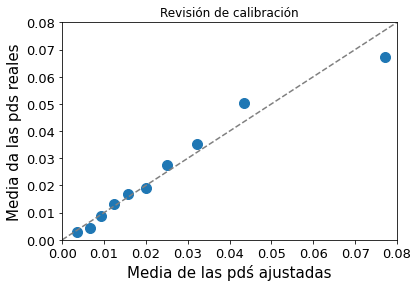

In [25]:
grafica_ajuste(data2_cpa.PD_logit_model, data2_cpa.default_time, data2_cpa.time)

El ajuste de las medias reales contra las medias ajustadas no presenta desviaciones considerables, incluso para valores dispersos esta comportamiento se mantiene.